# Final Topic Modeling: NMF

From my first round of modeling, I was able to conclude that NMF yielded the best topics and TFIDF vectorization appeared to be better than count vectorization. I also compared coherence scores and 15 topics seems to be optimal.

I will now run my final model and do some visualization.

In [11]:
# Import module
from topic_modeling import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Loading and preparing data

In [14]:
# Load preprocessed text
import pickle

infile = open('processed_text.pkl','rb')
text_l = pickle.load(infile)
infile.close()

In [15]:
# Further preprocess text (remove erroneous terms, remove additional stopwords)
text_l = prep_text(text_l)

In [16]:
# Define min_df and max_df (from EDA of text analysis)
min_df = 31
max_df = 6200

In [17]:
# Load PMIDs to use as abstract labels
import pickle

infile = open('pmids.pkl','rb')
pmids = pickle.load(infile)
infile.close()

## Model

In [26]:
# Vectorize text, create document-term matrix
tfidf, doc_word = vectorize_dtm(vectorizer_method='tfidf', text=text_l, min_df=min_df, max_df=max_df)

In [27]:
# Build model and create matrices
nmf_model, doc_topic_matrix, doc_topic_df, topic_word_df = \
nmf_model(n_components=20, dtm=doc_word, vectorizer=tfidf, abstract_labels=pmids)

/Users/sunnajo/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [28]:
# Look at topics
display_topics(nmf_model, tfidf.get_feature_names(), 30)


Topic  0
management, recommendation, emergency, guideline, world, prevention, control, organization, strategy, staff, diagnosis, society, experience, resource, guidance, challenge, protocol, team, consensus, professional, approach, safety, equipment, clinician, condition, consideration, document, personnel, expert, provider

Topic  1
cell, expression, receptor, host, gene, entry, tissue, cytokine, activation, inflammation, mechanism, immunity, lung, function, inflammatory, replication, pathway, damage, cytokine_storm, production, surface, macrophage, lymphocyte, interferon, spike, mouse, membrane, angiotensin_converting_enzyme, stem, epitope

Topic  2
mortality, admission, outcome, cohort, severity, comorbidities, hospitalization, association, hypertension, morbidity, mechanical_ventilation, incidence, odds, obesity, population, diabetes, predictor, ratio, laboratory, score, prevalence, dimer, adult, kidney, prognosis, survivor, male, meta, stay, comorbidity

Topic  3
child, adult, fa

In [35]:
# Name topics
topic_names = {0: 'clinical recommendations',
              1: 'pathophysiology',
              2: 'prognosis',
              3: 'children',
              4: 'cancer',
              5: 'mental health',
              6: 'diagnosis/serology',
              7: 'resources & technology',
              8: 'vaccine',
              9: 'predictions/forecasting',
              10: 'transmission',
              11: 'global impact',
              12: 'pregnancy',
              13: 'surgery',
              14: 'treatment',
              15: 'microbiology',
              16: 'education',
              17: 'clinical features',
              18: 'deaths',
              19: 'healthcare workers & PPE'}

# Topic labels
topic_labels = list(topic_names.values())

In [37]:
# Look at top words for each topic
word_topic_df = topic_top_words(vectorizer=tfidf, num_topics=len(topic_names), model=nmf_model, topic_labels=topic_labels)
word_topic_df

,clinical recommendations,pathophysiology,prognosis,children,cancer,mental health,diagnosis/serology,resources & technology,vaccine,predictions/forecasting,transmission,global impact,pregnancy,surgery,treatment,microbiology,education,clinical features,deaths,healthcare workers & PPE
0,management,cell,mortality,child,cancer,anxiety,antibody,community,vaccine,model,transmission,country,woman,surgery,trial,inhibitor,student,lung,death,worker
1,recommendation,expression,admission,adult,oncology,depression,detection,crisis,development,prediction,contact,world,pregnancy,surgeon,efficacy,compound,education,pneumonia,population,mask
2,emergency,receptor,outcome,family,breast,stress,assay,change,vaccination,parameter,control,spread,delivery,emergency,safety,target,school,injury,estimate,face
3,guideline,host,cohort,parent,tumor,disorder,sensitivity,policy,candidate,dynamic,spread,organization,outcome,operation,intervention,activity,university,diagnosis,state,equipment
4,world,gene,severity,adolescent,chemotherapy,survey,specificity,challenge,world,intervention,prevention,government,mother,activity,hydroxychloroquine,protease,college,failure,comorbidities,staff
5,prevention,entry,comorbidities,school,malignancy,score,serum,population,epitope,estimate,droplet,population,infant,staff,outcome,interaction,program,lesion,failure,protection
6,control,tissue,hospitalization,multisystem,lung,questionnaire,diagnosis,information,strategy,scenario,cluster,policy,birth,volume,protocol,receptor,online,ards,hospitalization,respirator
7,organization,cytokine,association,infant,delay,scale,titer,access,immunity,simulation,isolation,strategy,neonate,trauma,agent,host,course,chest,toll,work
8,strategy,activation,hypertension,childrens,oncologist,prevalence,neutralization,home,effort,accuracy,route,italy,newborn,reduction,randomization,structure,experience,severity,ratio,hcws
9,staff,inflammation,morbidity,condition,diagnosis,distress,spike,support,therapeutic,forecast,intervention,incidence,cesarean_section,resource,remdesivir,molecule,training,kidney,heart,exposure


In [45]:
# Save vectorizer
import pickle

outfile = open('tfidf.pkl','wb')
pickle.dump(tfidf,outfile)
outfile.close()

In [44]:
# Save model
import pickle

outfile = open('nmf_model.pkl','wb')
pickle.dump(nmf_model,outfile)
outfile.close()

In [46]:
# Save document-topic matrix
import pickle

outfile = open('doc_topic.pkl','wb')
pickle.dump(doc_topic,outfile)
outfile.close()

In [47]:
# Save document-term matrix
import pickle

outfile = open('doc_word.pkl','wb')
pickle.dump(doc_word,outfile)
outfile.close()

## Visualization

### t-SNE

In [22]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities, _kl_divergence)

import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')

/Users/sunnajo/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


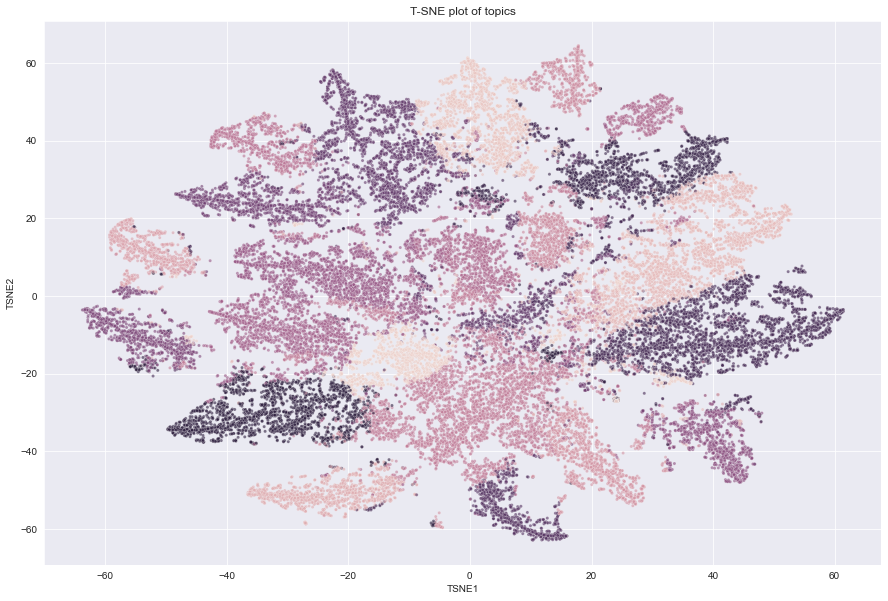

In [29]:
tsne = TSNE(n_components=2,
             perplexity=50,
             learning_rate=200,
             n_iter=1000,
             n_jobs=-1,
             random_state=0)

tsne_features = tsne.fit_transform(doc_topic)

df = pd.DataFrame(tsne_features)
df['topic'] = doc_topic.argmax(axis=1)
df.columns = ['TSNE1', 'TSNE2', 'topic']

# Plot
plt.figure(figsize=(15, 10))
plt.title('T-SNE plot of topics')
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='topic', data=df, s=10, alpha=0.6)
ax.get_legend().remove()
# plt.savefig('tsne.svg', dpi=100, bbox_inches='tight')

### Word Clouds

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [29]:
# Function for creating wordcloud
def wordcloud(df, i):
    text = ' '.join(list(df.iloc[:,i]))

    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=50, background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

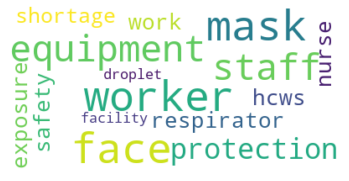

In [39]:
for i in range(len(topic_names)):
    wordcloud(word_topic_df, i)